# Face Reconstruction


Inpainting project done on https://paperswithcode.com/dataset/ffhq with custom inpainting. (due to limited capacities (1 4GB GPU per 2 people, we wre forced to use 128x128 format, with (mostly) a batch size of 8)

#### Basic imports for showing experiment worklow

In [15]:
from models.basic.Discriminator import Discriminator as BasicDiscriminator
from models.basic.Generator import Generator as BasicGenerator
from models.basic_2.Discriminator import  Discriminator as BasicDiscriminator_2
from models.basic_2.Generator import Generator as BasicGenerator_2
from models.AOT.Discriminator import Discriminator as Discriminator_AOT
from models.AOT.Generator import Generator as BasicGenerator_AOT
from models.double_gan.UNet import UNet as DoubleDiscriminator_UNet
from models.double_gan.UNet_maskAware import UNet_maskAware as DoubleGenerator_UNet
from models.double_gan.Generator import Generator as DoubleGenerator_AOT
from classes.Experiment import Experiment
from train import train
from config import n_epochs


End of pretraining


## Overfitting study on a variety of architectures: choosing good enough model


We decided to be  little adventurous and test out many different architectures, 
to test out which was the best fit/large enough fit we decided to perform an overfitting study on them. 

All of the architectures tested have Unet as the discriminator, but each end every architecture has different features.

In [7]:
# utility functions for notebook display 
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

def show_images(filenames, columns = 5, figsize = (20,10)):
        
    images = []
    for img_path in filenames:
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=figsize)
    for i, image in enumerate(images):
        plt.subplot(len(images)//(columns) + 1, columns, i + 1)
        plt.imshow(image)
        
def get_file_names(directory, structure, epoch = None, every_x_batches = 500, number_of_batches = 2550):
    filenames = [directory + "\\" + structure + str(batch) + ".png" for batch in range(0,number_of_batches, every_x_batches)]
    return filenames

### 1. Basic 
We overfitted all of the models on the first 100 photos of the dataset. With a minimal dropout rate of 0.01 for botch discriminator and generator. In order to compare results we'll examine the results after 500 batches, all of them being pretrained (100 batches) on pixelwise loss.



The first approah consists of a simple autoencoder-ish generator model with 6 downsampling blocks and 5 upsampling blocks. ( We tested fewer and this turned out to be one of the best combinations).

In [16]:
from train import train

In [ ]:
Baseline = Experiment(name = 'Overfit_Study_Baseline',
                              generator_models = [BasicGenerator_2],
                              discriminator_models = [DoubleDiscriminator_UNet],
                              generate_whole_image= False,
                              overfittingStudy=True,
                              pretrain = True,
                              dropout_generator = 0.01,
                              dropout_discriminator = 0.01,
                              epochs = n_epochs)

In [ ]:
train(Baseline)

The results of which were:

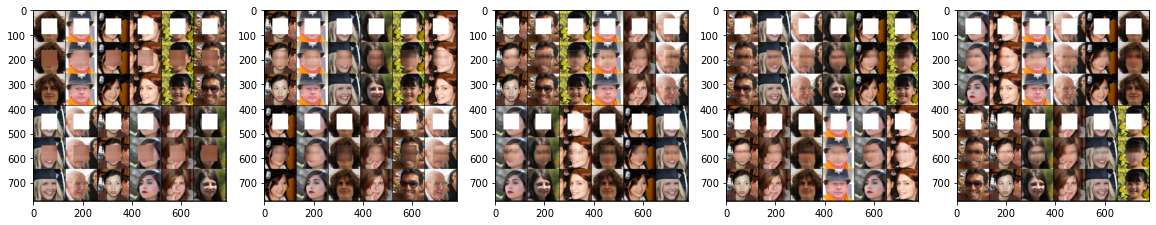

In [10]:
show_images(get_file_names("images\Overfit_Study_Baseline","", every_x_batches=600), columns = 5)

### 2. Double Unet

We decided toperform this example a bit out of curiosity: since Unet turned to be a good dicrriminator(in theory unet should output a per-pixel value of "fakeness" of the pixel combining local and global loss), we thought of using the Unet architecture as the generator too. The only tweak beaing the generator Unet being mask-aware (obviosly not implemented in discriminator). Sadly this approach failed to perform well in practice.

In [ ]:
double_unet = Experiment(name = 'Overfit_Study_DoubleUnet',
                              generator_models = [DoubleGenerator_UNet],
                              discriminator_models = [DoubleDiscriminator_UNet],
                              generate_whole_image= True,
                              overfittingStudy=True,
                              pretrain = True,
                              dropout_generator = 0.01,
                              dropout_discriminator = 0.01,
                              epochs = n_epochs)

In [ ]:
train(double_unet)

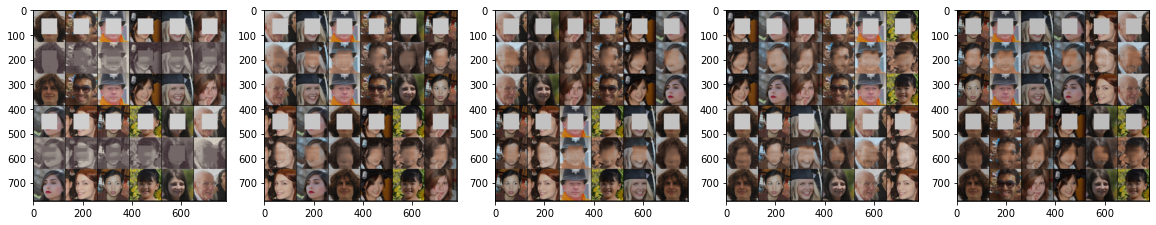

In [11]:
show_images(get_file_names("images\Overfit_Study_DoubleUnet","", every_x_batches=600), columns = 5)

### 3. AOT

In the third approach we decided to adapt a model specifically for the inpainting task. This is the link to the paper:https://arxiv.org/abs/2104.01431, the special thing about AOT is the generator that exploits aggregated contextual transformations of distant image contexts for enhancing context reasoning.


*Specifically, the AOT blocks adopt the split-transform-merge strategy. First, an AOT block splits the kernel of a standard convolution into* *multiple sub- kernels. Second, it applies each sub-kernel on the incoming features with different dilation rates. Finally, the AOT block* *aggregates different transformations from all the sub-kernels as output (Fig. 3-(b)). Through these three steps, informative distant* 
*image contexts are leveraged by using various dilation rates, while rich patterns of interest are captured by aggregating multiple* *transformation results, leading to better context reasoning for missing regions*

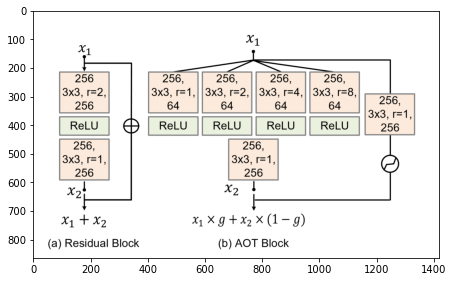

In [12]:
show_images(["images/presentation/AOT_block.png"], columns=1)

In [2]:
aot = Experiment(name = 'Overfit_Study_AOT',
                              generator_models = [BasicGenerator_AOT],
                              discriminator_models = [DoubleDiscriminator_UNet],
                              generate_whole_image= True,
                              overfittingStudy=True,
                              pretrain = True,
                              dropout_generator = 0.1,
                              dropout_discriminator = 0.1,
                              epochs = n_epochs)

In [2]:
train(aot)

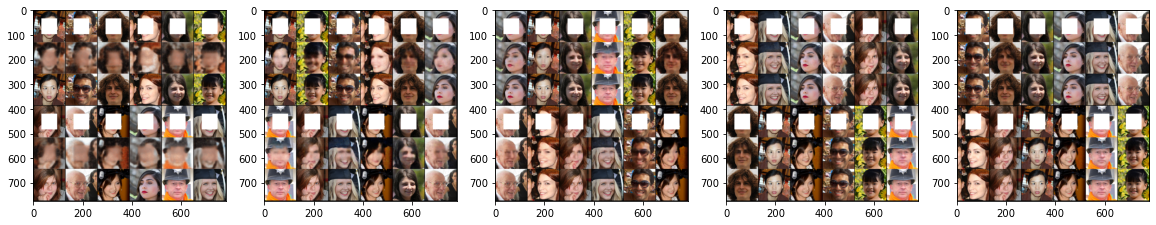

In [13]:
show_images(get_file_names("images\Overfit_Study_AOT","", every_x_batches=600), columns = 5)

And there we have it, clearly AOT seemed to be the best one, although we did not implement everythin th paper stated ( like the masked discriminator, in the original one they weren't using unet too).

## Experiments with dropout 
We did compare adding dropout to the AOT, although this was not the base in the original architecture.
We tried dropout 0.1 and 0.05 and are almost sure that the latter had a better performance.

In [5]:
vanilla_aot_unet = Experiment(name = 'Vanilla_AOT_3_dropout_005',
                              generator_models = [BasicGenerator_AOT],
                              discriminator_models = [DoubleDiscriminator_UNet],
                              generate_whole_image= True,
                              overfittingStudy=False,
                              pretrain = True,
                              dropout_generator = 0.05,
                              dropout_discriminator = 0.05,
                              epochs = 5)

In [ ]:
train(vanilla_aot_unet)

In [3]:
import torch
torch.cuda.empty_cache()

In [4]:
vanilla_aot_unet_2 = Experiment(name = 'Vanilla_AOT_3_dropout_01',
                              generator_models = [BasicGenerator_AOT],
                              discriminator_models = [DoubleDiscriminator_UNet],
                              generate_whole_image= True,
                              overfittingStudy=False,
                              pretrain = True,
                              dropout_generator = 0.1,
                              dropout_discriminator = 0.1,
                              epochs = 5)

In [ ]:
train(vanilla_aot_unet_2)

### Different loss functions
#### Content loss
In the examples before, the model was trained using pixelwise loss compared with adversarial learning, since the model should have some creative freedom we introduced an additional loss - content loss implemented by doing a forward pass of botch the original image and generated image on the vgg19 model, pretrained on the imagenet dataset, this was done on 5 first layers of the vgg19, and the loss equals the difference of the weights in the model, this at first seemed to work pretty well but the generator - discriminator balance got out of hand pretty quickly.


**TODO: Paste link to neptune**

In [17]:
vanilla_aot_unet_style_loss = Experiment(name = 'Vanilla_AOT_3_dropout_01_style_loss_volm',
                              generator_models = [BasicGenerator_AOT],
                              discriminator_models = [DoubleDiscriminator_UNet],
                              generate_whole_image= True,
                              overfittingStudy=False,
                              pretrain = True,
                              dropout_generator = 0.1,
                              dropout_discriminator = 0.1,
                              epochs = 5,
                              style_loss=True)

In [ ]:
train(vanilla_aot_unet_style_loss)

Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterConnectionError
Experiencing connection interruptions. Will try to reestablish communication with Neptune. Internal exception was: RequestsFutureAdapterTimeout
Communication with Neptune restored!
Communication with Neptune restored!


#### Style loss
Event before we implemented the content loss we tried to work with style loss ( computed by multiplying gram matrices ) and content loss simultaniously, the style loss ( this might be a bug in out implementation) was inherently much bigger than the content loss, overpowering the latter, so after multiple tries of adapting it ( decreasing weights of layer activation, changing alpha - beta coefficients).

#### Pixelwise loss
In the end all of the succesfull experiments were conduncted by using the pixelwise loss (L1 norm). 

#### Future work
An optimal approach be perhaps be combinging pixelwise loss and content loss, ommiting the style loss.

## Discriminator and Generator balancing


Many experiments (look above) - and those especially at the evry beginning of our research resulted in a drastic imabalnce in generator and discriminator, when the loss of the discriminator converged to 0 and the generator loss shooted up, this is obviously unwanted behaviour, however this problem can be solved with a training schedule, however training the discriminator every 5th batch ( for example) might result in unstable training where the discriminator isstill trained too much or not enough. This is why we introduced **loss slope dependant training schedule**, the logic of which can be seen below:

In [ ]:
def balanceD_and_G(self, batches_done, batch_scors_G, batch_scores_D):
    '''
    Returns boolean values train_G and train_D
    '''
    slope_scope = self.balancig_length
    if len(batch_scors_G) < slope_scope:
        return True, True
    discriminator_slope, _, _, _, _ = linregress(range(slope_scope), batch_scores_D[-slope_scope:])  
    generator_slope, _, _, _, _ = linregress(range(slope_scope), batch_scors_G[-slope_scope:])
    if generator_slope > 0 or discriminator_slope < 0:
        return True, False
    if discriminator_slope > 0:
        return True, True
    else:
        return True, True

This approach ( for example ) guaranteed us stable training for the aot ( w/o it it would perform in a weirder way, this approach is not perfect but improved generator and discriminator synch-up)


Below you can see an extreme example of what happens when thegenerator and discriminator are out of synch:

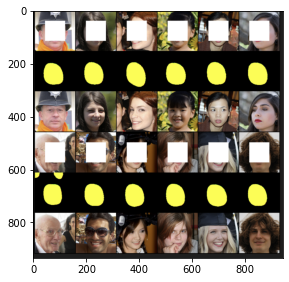

In [19]:
show_images(["images/presentation/crazy.png"], columns=1)

similarly, but this time the generator hails the revolution...

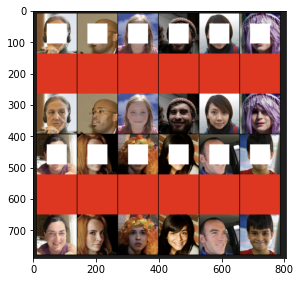

In [20]:
show_images(["images/presentation/communism.png"], columns=1)

### Future Work


The topic of gans in general (not only image-inpainting gans) deeper that the Rów Mariacki and broader than the horions after graduating Politechnika Poznańska... We had a plethora of ideas of how to tweak the model and our project, just to name a few examples:
- impement pixelwise and content loss together
- stratify by race ( so that batches have a quasi-equal race ratio) - the model oftem mad asian people appear causcasian and vice versa
- oversample based on races ( majority of peoples' face in our dataset were white)

Overall we found the project interesting haha...